# **Analysis & Trends on Covid19 in Africa**

In [ ]:
# Installs
!pip install folium
!pip install calmap

<hr>

# Library Importation
<hr> 


In [1]:
#for data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for visualization
from matplotlib import ticker
import seaborn as sns
import folium
import branca
import plotly.express as px

# date features
from datetime import datetime, timedelta,date

from scipy.interpolate import make_interp_spline, BSpline
import json, requests
import calmap
import wget

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [29]:
# Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_cases.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_deaths.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19africa/master/data/time_series/africa_daily_time_series_recovered.csv')


In [30]:
df_recovered.head(2)

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,1508,1558,1651,1702,1779,1821,1872,1936,1998,2067
1,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,6,6,6,7,7,11,11,11,11,11


<hr>

# Preprocessing 
<hr>

In [4]:
df_active = df_confirmed.copy()
df_active.iloc[:,3:] = df_active.iloc[:,3:] - df_recovered.iloc[:,3:] - df_deaths.iloc[:,3:]
df_active.head(5)

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20
0,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,1561,1702,1777,1880,1964,2075,2185,2301,2324,2376
1,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,19,18,18,17,22,22,22,23,23,23
2,Benin,9.3077,2.3158,0,0,0,0,0,0,0,...,30,30,30,46,46,46,44,44,44,85
3,Botswana,-22.3285,24.6849,0,0,0,0,0,0,0,...,22,17,17,14,14,14,14,14,14,13
4,Burkina Faso,12.2383,-1.5616,0,0,0,0,0,0,0,...,120,100,96,88,73,77,81,92,126,126


In [5]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
df_recovered = df_recovered.replace(np.nan, '', regex=True)
df_active = df_active.replace(np.nan, '', regex=True)

In [6]:
dates = df_confirmed.columns[3:].to_list()
conf_df_long = df_confirmed.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='ConfirmedCases')

deaths_df_long = df_deaths.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = df_recovered.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                             value_vars=dates, var_name='Date', value_name='Recovered')
active_df_long = df_active.melt(id_vars=['Country/Region', 'Lat', 'Long'], 
                             value_vars=dates, var_name='Date', value_name='Active')

df_combined = pd.concat([conf_df_long, deaths_df_long['Deaths'],recv_df_long['Recovered'],active_df_long['Active']], axis=1, sort=False)

df_combined.head()

,Country/Region,Lat,Long,Date,ConfirmedCases,Deaths,Recovered,Active
0,Algeria,28.0339,1.6596,1/22/20,0,0,0,0
1,Angola,-11.2027,17.8739,1/22/20,0,0,0,0
2,Benin,9.3077,2.3158,1/22/20,0,0,0,0
3,Botswana,-22.3285,24.6849,1/22/20,0,0,0,0
4,Burkina Faso,12.2383,-1.5616,1/22/20,0,0,0,0


In [7]:
df_combined.Date = df_combined.Date.astype('datetime64[ns]')

 <hr>
 
 # Defining Functions
 <hr>
 
* plot_params()
* visualize_covid_cases()
* get_mortality_rate()

In [8]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["Country/Region",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases in Africa",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()

def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["Country/Region",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

<hr>

# E.D.A.

<hr>

In [9]:
df_africa_cases = df_combined.loc[df_combined['Date'] == df_combined['Date'].max()]
df_africa_cases = df_africa_cases.drop(['Lat','Long','Date'], axis=1)
df_africa_cases.index = df_africa_cases['Country/Region']
df_africa_cases = df_africa_cases.drop(['Country/Region'], axis=1)
df_africa_cases.head()

,ConfirmedCases,Deaths,Recovered,Active
Country/Region,,,,
Algeria,5182,483,2323,2376
Angola,36,2,11,23
Benin,140,2,53,85
Botswana,23,1,9,13
Burkina Faso,736,48,562,126


<hr>

### Total Reported Cases in Africa till Date
<hr>
Total number of confirmed cases, deaths reported, recovery cases, active cases and Mortality Rate across africa

In [10]:
df_t = pd.DataFrame(pd.to_numeric(df_africa_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["ConfirmedCases"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}",subset=["ConfirmedCases"])
#df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}")

,ConfirmedCases,Deaths,Recovered,Active,Mortality Rate (per 100)
0,54039,2073,18393,33573,3.84


<hr>

### Country Wise Reported Cases
<hr>
Country Wise reported confirmed cases, recovered cases, deaths, active cases

In [11]:
# df_countries_cases.sort_values('Confirmed', ascending= False).style.background_gradient(cmap='Wistia')
df_africa_cases["Mortality Rate (per 100)"] = np.round(100*df_africa_cases["Deaths"]/df_africa_cases["ConfirmedCases"],2)
df_africa_cases.sort_values('ConfirmedCases', ascending= False).style.background_gradient(cmap='Blues',subset=["ConfirmedCases"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,ConfirmedCases,Deaths,Recovered,Active,Mortality Rate (per 100)
Country/Region,,,,,
South Africa,8232,161,3153,4918,1.96
Egypt,7981,482,1887,5612,6.04
Morocco,5548,183,2179,3186,3.3
Algeria,5182,483,2323,2376,9.32
Nigeria,3526,107,601,2818,3.03
Ghana,3091,18,303,2770,0.58
Cameroon,2267,108,1002,1157,4.76
Guinea,1927,11,629,1287,0.57
Cote d'Ivoire,1571,20,742,809,1.27


<hr>

### Top 10 affected countries (Confirmed Cases, Deaths, Active and Recovered)
<hr>

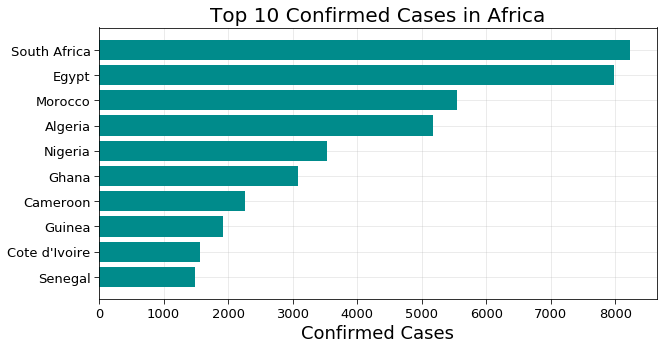

In [12]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_africa_cases.sort_values('ConfirmedCases')["ConfirmedCases"].index[-10:],df_africa_cases.sort_values('ConfirmedCases')["ConfirmedCases"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Confirmed Cases in Africa",fontsize=20)
plt.grid(alpha=0.3)
#plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

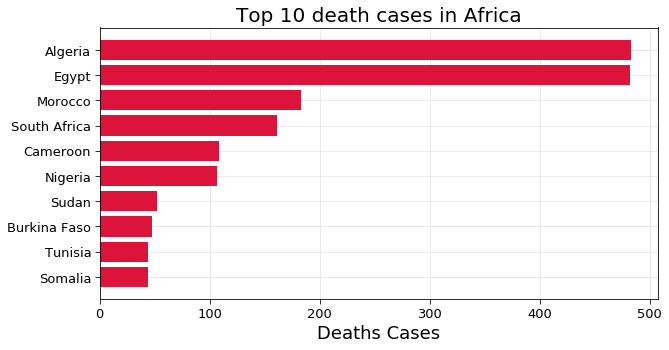

In [13]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_africa_cases.sort_values('Deaths')["Deaths"].index[-10:],df_africa_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 death cases in Africa",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

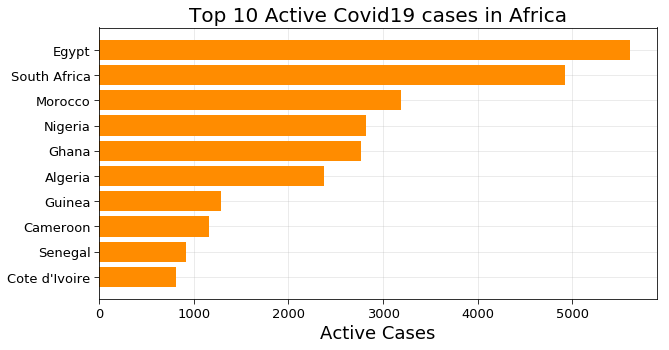

In [14]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_africa_cases.sort_values('Active')["Active"].index[-10:],df_africa_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Active Covid19 cases in Africa",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Active Cases).png')

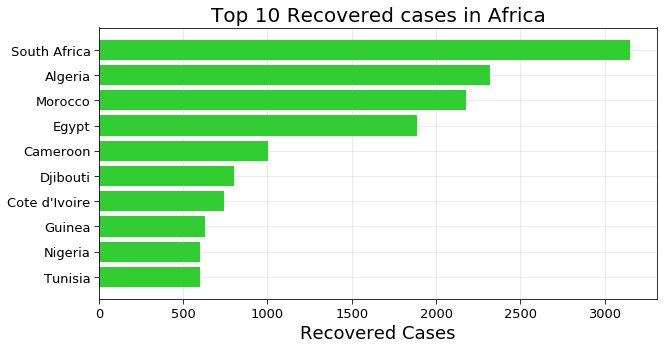

In [15]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_africa_cases.sort_values('Recovered')["Recovered"].index[-10:],df_africa_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Recovered cases in Africa",fontsize=20)
plt.grid(alpha=0.3,which='both')
#plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

<hr>

# Calander Map
<hr>

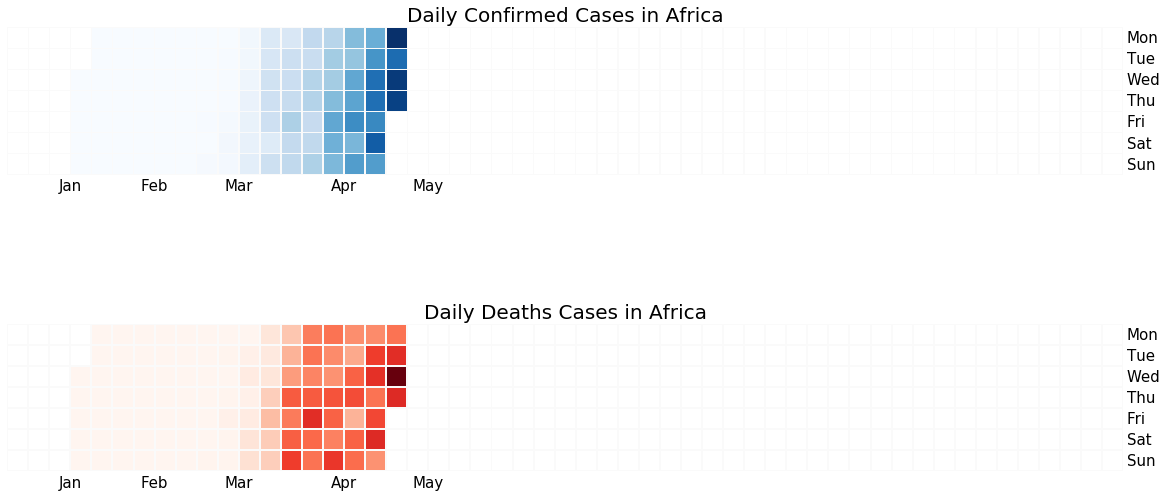

In [16]:

fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,1,1)
calmap.yearplot(df_combined.groupby('Date')['ConfirmedCases'].sum().diff(), fillcolor='white', cmap='Blues', linewidth=0.5, monthlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May'], linecolor="#fafafa",year=2020,)
plt.title("Daily Confirmed Cases in Africa",fontsize=20)
plt.tick_params(labelsize=15)

fig.add_subplot(2,1,2)
calmap.yearplot(df_combined.groupby('Date')['Deaths'].sum().diff(), fillcolor='white', cmap='Reds', linewidth=1, monthlabels=['Jan', 'Feb', 'Mar', 'Apr', 'May'], linecolor="#fafafa",year=2020,)
plt.title("Daily Deaths Cases in Africa",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

<hr>

# Correlation Analysis
<hr>
Plotting Heat map of correlation of confirmed cases, recovered cases, deaths and active cases.

In [17]:
df_africa_cases.iloc[:,:].corr().style.background_gradient(cmap='Reds')

,ConfirmedCases,Deaths,Recovered,Active,Mortality Rate (per 100)
ConfirmedCases,1,0.82396,0.932585,0.978681,0.0172329
Deaths,0.82396,1,0.781078,0.773459,0.232853
Recovered,0.932585,0.781078,1,0.840438,0.0417619
Active,0.978681,0.773459,0.840438,1,-0.0148944
Mortality Rate (per 100),0.0172329,0.232853,0.0417619,-0.0148944,1


* There are 0.81 positive correlation between Deaths and Confirmed Cases.
* 0.94 positive correlation between Recovered and Confirmed Cases.
* 0.98 positive Correlation between Active and Confirmed Cases.
* 0.07 positive correlation between Mortality Rate and Confirmed Cases
* 0.77 positive correlation between Recovered and Deaths Cases
* Active and Deaths cases
* Mortality rate and Deaths Cases
* Active and Recovered Cases
* Mortality rate and Recovered Cases
* Mortality rate and Active Cases

#  2.  Spread Trends in the Africa, and few most affected Countries
<hr>

1. COVID-19 Spread Trends in Africa
2. COVID-19 Spread Trends in Few Most Affected Countries
3. COVID-19 Spread Comparison of few most affected countries
4. COVID-19 Spread Comparison of in different continents



### 1. COVID-19 Spread Trends in Africa
<h>
This graph shows the confirmed, deaths, recovered and active cases trends in Africa.


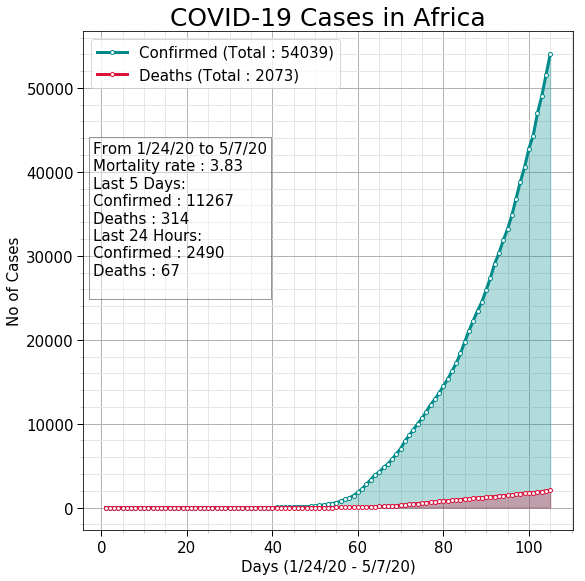

In [18]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))

visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

#plt.savefig(out+'COIVD-19-World.png')
plt.show()

### 3. COVID-19 Spread Trends in Few Most Affected Countries

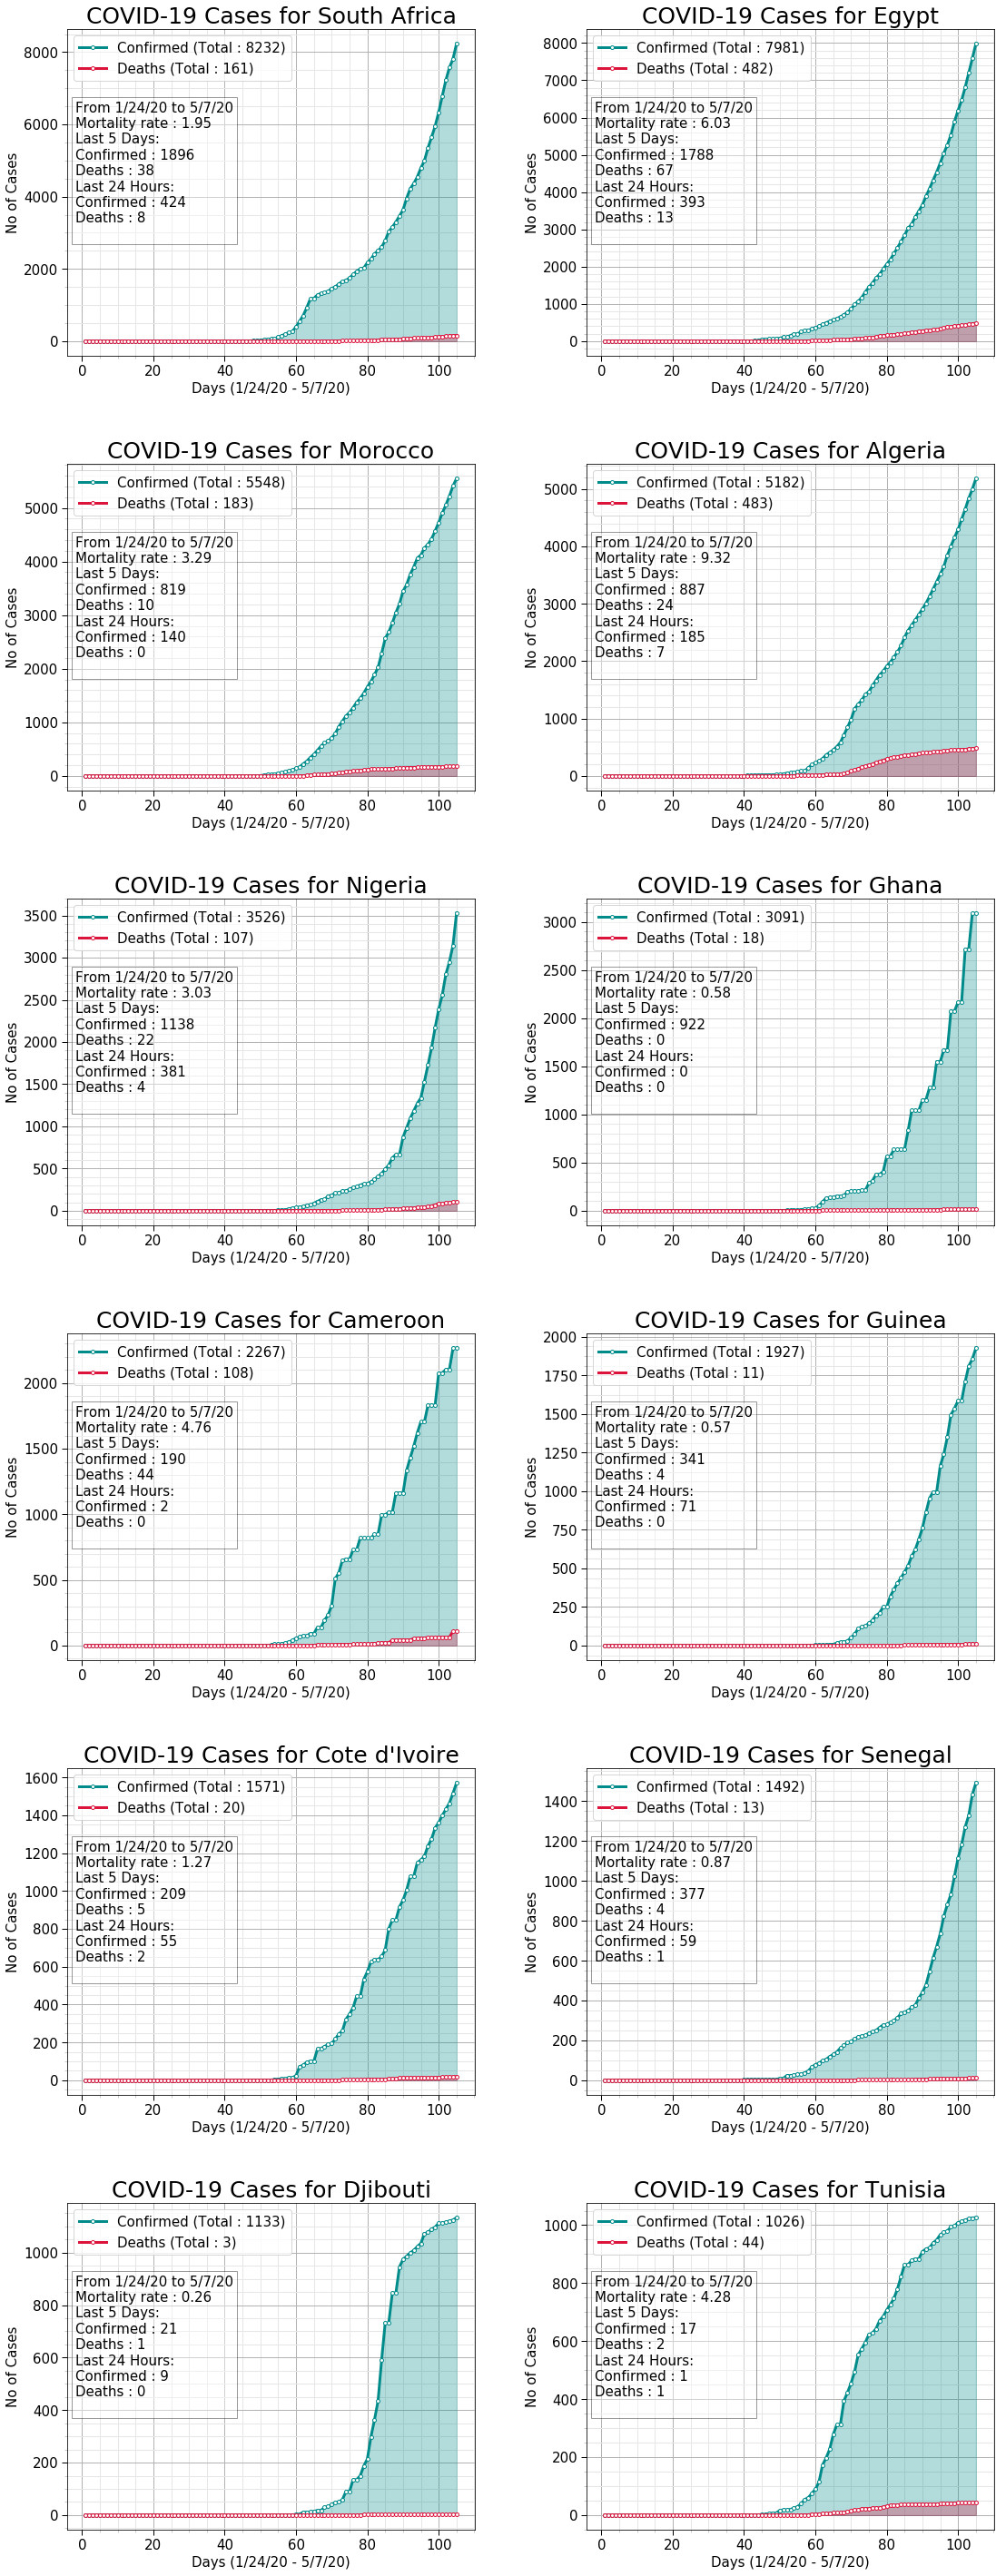

In [19]:
df_countries = df_confirmed.groupby(["Country/Region"]).sum()
df_countries = df_countries.sort_values(df_countries.columns[-1],ascending = False)
countries = df_countries[df_countries[df_countries.columns[-1]] >= 1000].index

cols =2
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(18,7*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

### 4. COVID-19 Spread Comparison of few most affected countries and NIGERIA

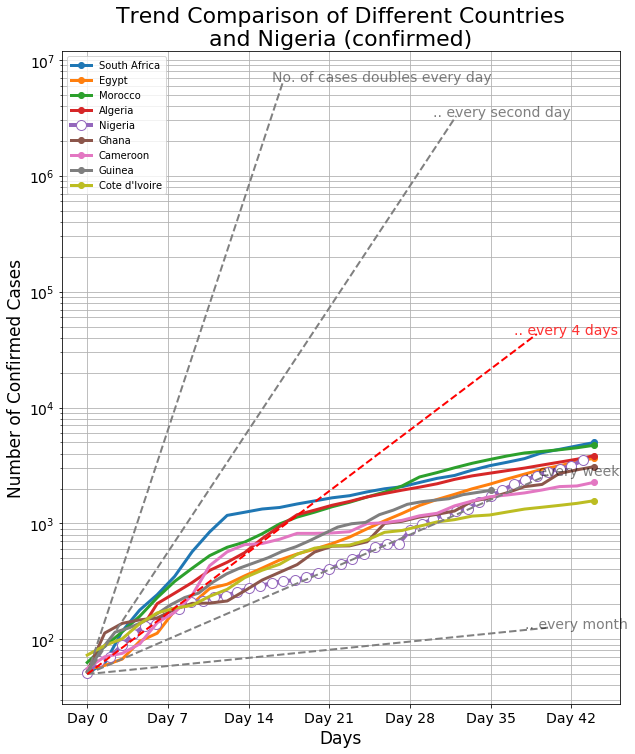

In [20]:
temp = df_confirmed.groupby('Country/Region').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 9:
        if country != "Nigeria":
            continue
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != "Nigeria":
        plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])
    else:
        marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
        plt.plot(date,t,"-.",label = country,**marker_style)

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-12))
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-4))
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-4))
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = np.arange(0,int(days-5))
y = 2**(x/4+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. every 4 days",(x[-3],y[-1]),color="Red",xycoords="data",fontsize=14,alpha = 0.8)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Countries\n and Nigeria (confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
#plt.savefig(out+'Trend Comparison with Nigeria (confirmed).png')
plt.show()

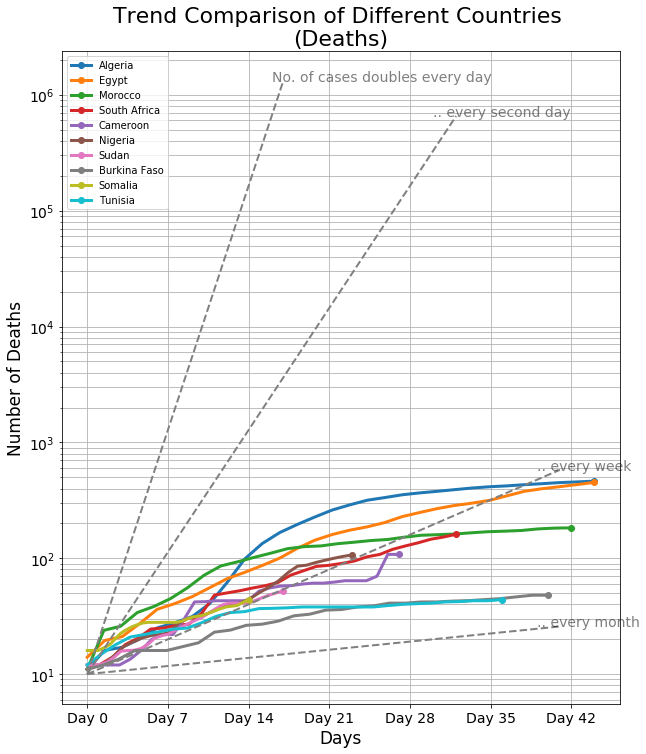

In [21]:
temp = df_deaths.groupby('Country/Region').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Countries \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
#plt.savefig(out+'Trend Comparison countries deaths.png')
plt.show()

# COVID-19 Daily Analysis
<hr>


## 1. Daily New Confirmed Cases and Deaths

NameError: name 'prediction_days' is not defined

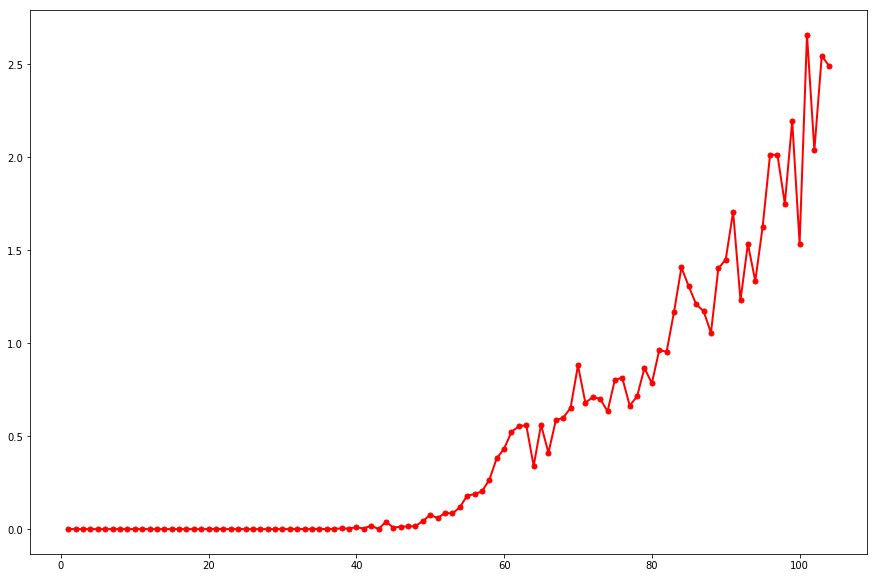

In [23]:
# Data
thousand = 1000
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily New Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.tick_params(labelsize = 13) 
#plt.savefig(out+"daily confirmed cases global.png")
plt.show()

NameError: name 'prediction_days' is not defined

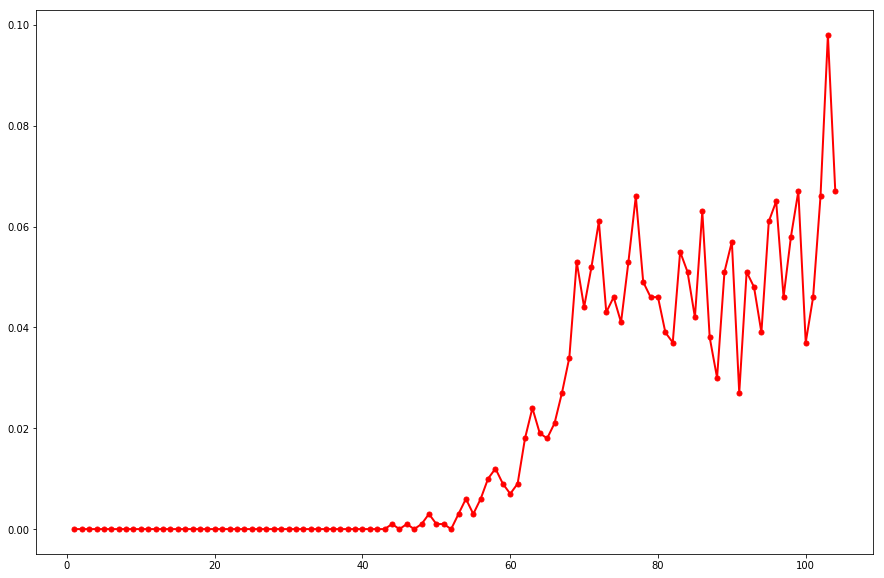

In [24]:
# Data
temp_data = np.nan_to_num(df_deaths.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily Deaths Reported",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
#plt.savefig(out+"daily deaths cases Global.png")
plt.show()

<hr>

# COVID-19 Case (Confirmed and Deaths) Percent Split in Different countries (Pie Viz)
<hr>
The pie plots below shows the proportion of the spread of this Pandemic across Africa. Each pie is showing a few major contributor countries, and rest countries are shown as "Others". Criteria :

* Confirmed Cases: Any country that has more than 500 confirmed cases are shown, the rest of the countries are under "others" Category.
* Deaths: Any Country that has more than 10 deaths are shown, the rest of the countries are under "others" Category.
* Active Cases: Any Country that has more than 500 active cases are shown, the rest of the countries are under "others" Category.
* Recovered Cases: Any Country that has more than 400 recoveries are shown rest of the countries are under "others" Category.

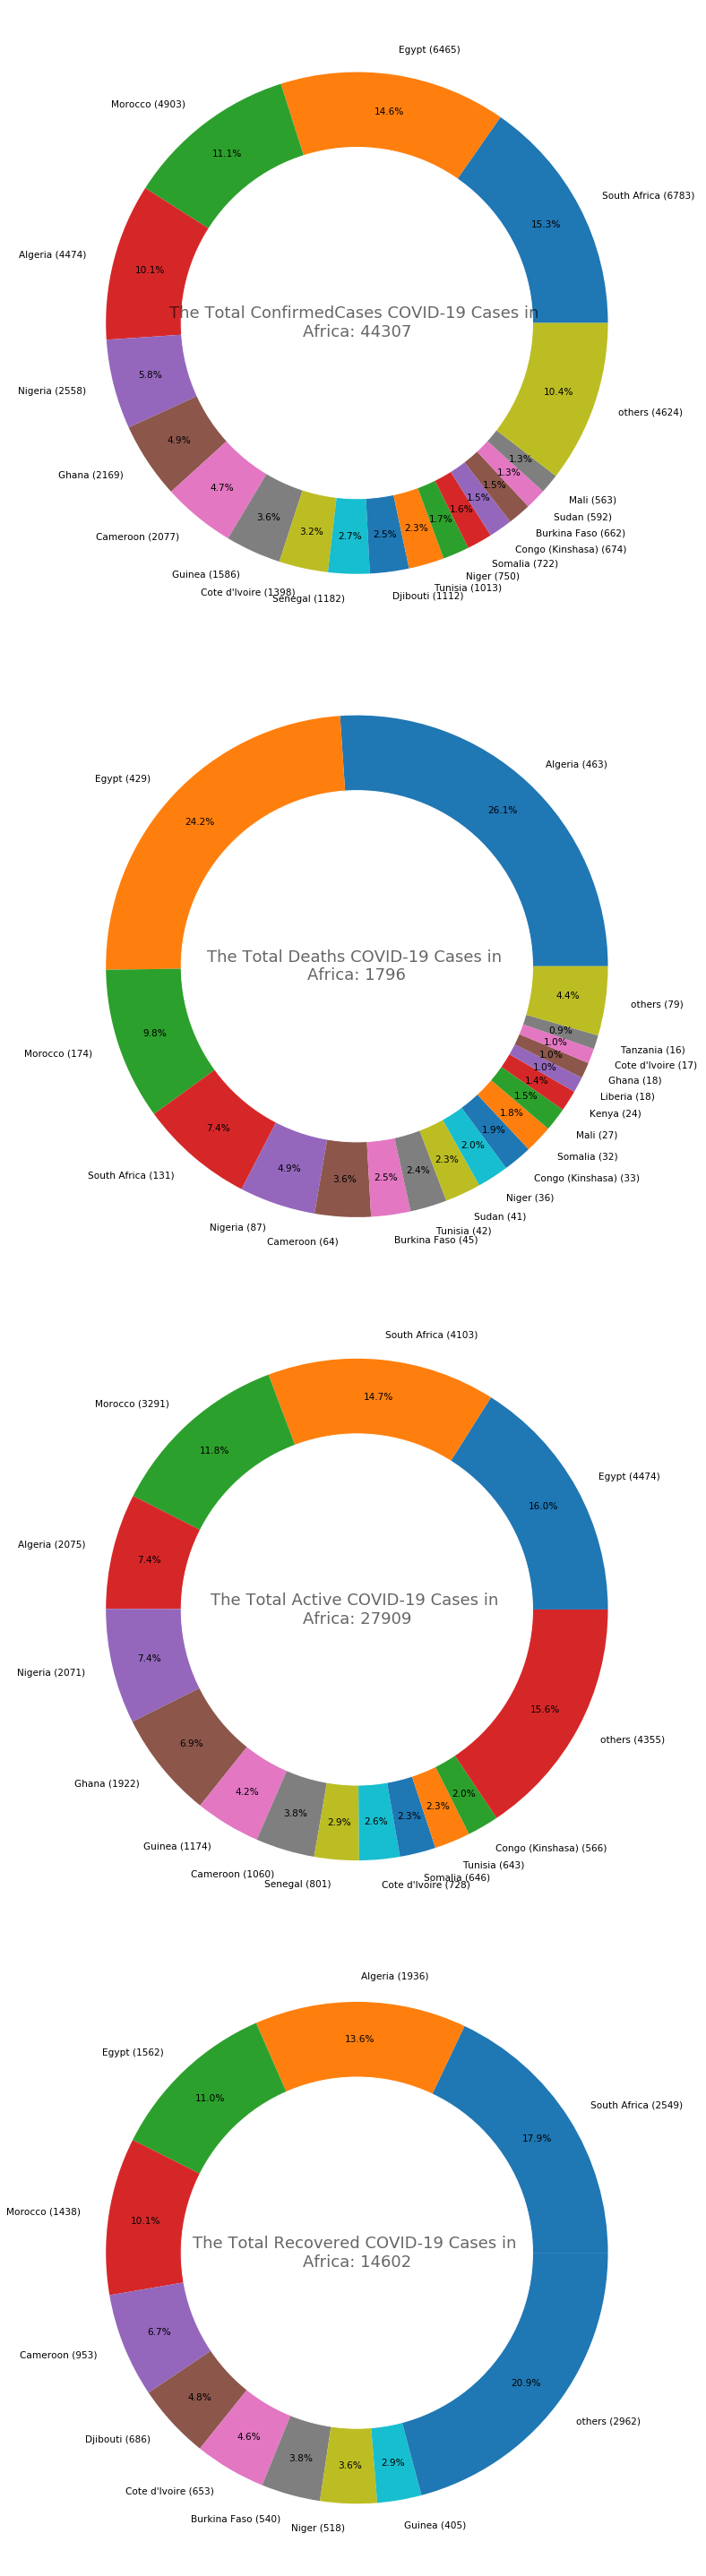

In [105]:
df_africa_pie = df_combined.loc[df_combined['Date'] == df_combined['Date'].max()]

rows = 4
f = plt.figure(figsize=(15,10*rows))

stats = [df_africa_pie.loc[:,['Country/Region','ConfirmedCases']],df_africa_pie.loc[:,['Country/Region','Deaths']],df_africa_pie.loc[:,['Country/Region','Active']],df_africa_pie.loc[:,['Country/Region','Recovered']]]
label = ["ConfirmedCases","Deaths","Active","Recovered"]
threshold = [500,10,500,400]
for i, stat in enumerate(stats):
    plt.tight_layout()
    df_countries = stat.groupby(["Country/Region"]).sum()
    df_countries = df_countries.sort_values(df_countries.columns[-1],ascending= False)
    others = df_countries[df_countries[df_countries.columns[-1]] < threshold[i] ].sum()[-1]
    df_countries = df_countries[df_countries[df_countries.columns[-1]] > threshold[i]]
    df_countries = df_countries[df_countries.columns[-1]]
    df_countries["others"] = others
    labels = [df_countries.index[i] +" (" + str(int(df_countries[i])) +") "for i in range(df_countries.shape[0])]

    ax = f.add_subplot(rows,1,i+1)
    plt.pie(df_countries, labels=labels,autopct='%1.1f%%',pctdistance=0.85, labeldistance=1.1,textprops = {'fontsize':10.5})
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.text(0.5,0.5,"The Total "+label[i]+ " COVID-19 Cases in \nAfrica: "+str(stat.sum().values[1]), horizontalalignment='center',verticalalignment='center',transform=ax.transAxes, size=18, alpha = 0.6)


plt.show()


# COVID-19 Mortality Rate Variation Over Period of Time
<hr>
Mortality Rate is the measure of number of deaths in a particular population during a specific interval.

* The curve shows how the mortality rate varies from 14 FEB 2020 to till date in Africa. 


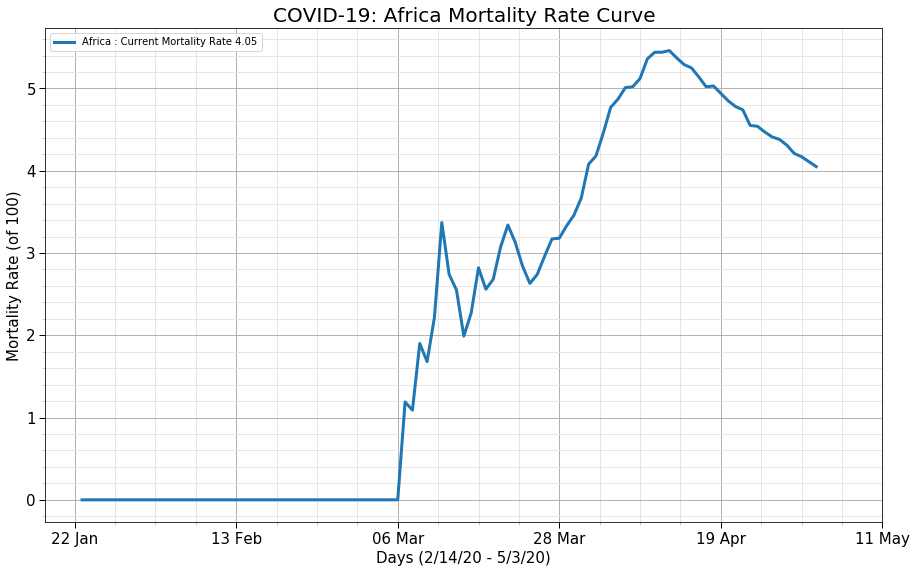

In [109]:
df_countries= df_confirmed.groupby(["Country/Region"]).sum()
countries = df_countries.sort_values(df_countries.columns[-1],ascending = False).index
countries = ["All"]+list(countries)

cols =1
rows = 2
axis_label = ["Days ("+df_confirmed.columns[26]+" - "+df_confirmed.columns[-1]+")","Mortality Rate (of 100)"]

f = plt.figure(figsize=(15,10*rows))

#SubPlot 1
ax = f.add_subplot(211)
mortality_rate = get_mortality_rate(df_confirmed,df_deaths,country=countries[0])
plt.plot(np.arange(1,mortality_rate.shape[0]+1),mortality_rate,label = "Africa : Current Mortality Rate "+str(mortality_rate[-1]),linewidth=3)

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

plt_title = "COVID-19: Africa Mortality Rate Curve"
plot_params(ax,axis_label,plt_title)
# Legend Location
l = plt.legend(loc= "best")
#plt.savefig(out+'Mortality rate.png')
plt.show()

All thanks to [Tarun Kumar](https://www.kaggle.com/tarunkr)